In [1]:
import pandas as pd
import numpy as np
import scipy 

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from random import choices,sample

import os
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

from datetime import timedelta

plt.style.use('ggplot')

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"

os.chdir("../../")
root_path = os.getcwd()

raw_file_path = os.path.join(root_path, "Bigcon2020_raw_file")
csv_file_path = os.path.join(root_path, "BigCon_2020/csv_files")
pickle_file_path = os.path.join(root_path, "BigCon_2020/pickle_files")

raw_file_folders = os.listdir(raw_file_path)

folder_path = os.path.join(raw_file_path, raw_file_folders[0])

c:\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
card_files = [file for file in os.listdir(csv_file_path) if file.startswith('카드')]

In [3]:
df_list = []

for file_name in card_files:
    file_path = os.path.join(csv_file_path, file_name)
    df = pd.read_csv(file_path)
    df_list.append(df)

In [4]:
foreigner = df_list[1]
register = df_list[0]

register = register.drop(register.columns[0], axis=1)
foreigner = foreigner.drop(foreigner.columns[0], axis=1)

In [5]:
cat_dict = {10 : '숙박',
20 : '레저용품',
21 : '레저업소',
22 : '문화취미',
30 : '가구',
31 : '전기',
32 : '주방용구',
33 : '연료판매',
34 : '광학제품',
35 : '가전',
40 : '유통업',
42 : '의복',
43 : '직물',
44 : '신변잡화',
50 : '서적문구',
52 : '사무통신',
60 : '자동차판매',
62 : '자동차 정비',
70 : '의료기관',
71 : '보건위생',
80 : '요식업소',
81 : '음료식품',
92 : '수리서비스'}

In [6]:
# foreigner.groupby('COUNTRY_NM')[['USE_CNT','USE_AMT']].sum().reset_index().sort_values(by=['USE_AMT','USE_CNT'], ascending=[0,0])

In [7]:
with open(os.path.join(pickle_file_path,'card_code_to_name_dict.pickle'), 'rb') as f:
    card_code_to_dong_dict = pickle.load(f)

register['region_code'] = register.GU_CD.astype(str)+register.DONG_CD.astype(str)
register['HDONG_NM'] = register.region_code.map(card_code_to_dong_dict.get('행정동명'))
register['MCT_CAT_NM'] = register.MCT_CAT_CD.map(cat_dict)

register['STD_DD'] = pd.to_datetime(register['STD_DD'], format='%Y%m%d')

register['year'] = register['STD_DD'].dt.year.values
register['month'] = register['STD_DD'].dt.month.values
register['weekofyear'] = register['STD_DD'].dt.weekofyear.values
register['dayofweek'] = register['STD_DD'].dt.dayofweek.values

register['weekday'] = np.where(register.dayofweek<5,'평일','주말')

### 객단가 

In [9]:
register.head()

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM
0,20190201,110,517,10,F,25,11,595,110517,동인동
1,20190201,110,517,10,F,50,5,243,110517,동인동
2,20190201,110,517,10,F,55,5,27,110517,동인동
3,20190201,110,517,10,M,20,11,243,110517,동인동
4,20190201,110,517,10,M,25,11,433,110517,동인동


In [62]:
register.drop(['DONG_CD','GU_CD','region_code'], axis=1, inplace=True)

#### 성별별 객단가 

In [63]:
tmp_df = register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        get_group(('소공동','M')).\
        iloc[:,3:]

In [64]:
tmp_df.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=7).mean().fillna(method='bfill').mean()

17.55063825931306

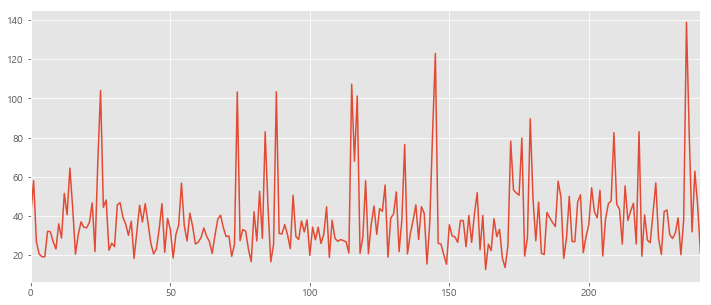

In [29]:
tmp_df.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.plot(figsize=(12,5))

In [94]:
register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup').\
        pivot_table(index='SEX_CD',columns='HDONG_NM',values='mean_daily_gup')

HDONG_NM,고산1동,고산2동,고산3동,공릉1동,공릉2동,광희동,남산1동,남산2동,남산3동,남산4동,...,지산2동,청구동,파동,필동,하계1동,하계2동,황금1동,황금2동,황학동,회현동
SEX_CD,,,,,,,,,,,,,,,,,,,,,
F,23.223873,29.779541,21.313296,21.725311,16.254400,28.345256,26.917874,33.335718,17.852205,30.692376,...,24.921699,17.737125,24.709514,13.534662,24.825368,12.679215,18.374014,56.065683,30.069290,50.219769
M,22.645632,31.523312,21.190795,21.867278,17.526868,27.162539,30.258360,35.122461,25.111804,26.202475,...,23.468563,16.452198,26.829940,14.411895,22.947493,11.105243,16.933946,47.002573,29.474147,39.765151


In [96]:
GUP_by_SEX_CD = register.groupby(['HDONG_NM','SEX_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup')

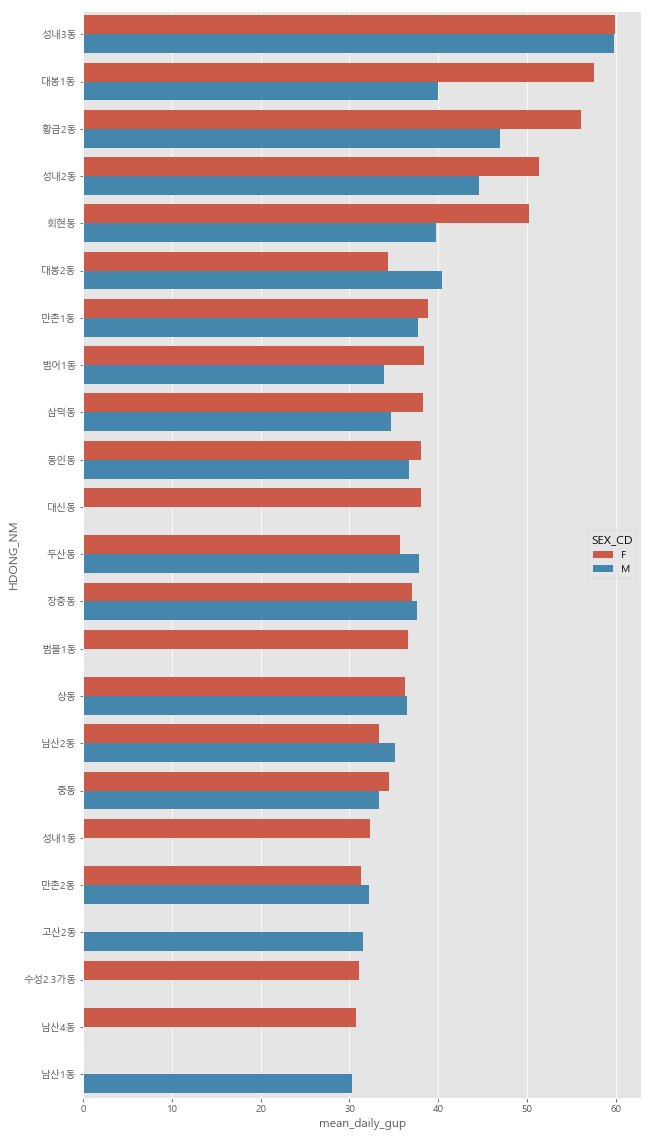

In [109]:
plt.figure(figsize=(10,20))
sns.barplot(
    data = GUP_by_SEX_CD.sort_values(by='mean_daily_gup', ascending=False).head(39),
    y = 'HDONG_NM',
    x = 'mean_daily_gup',
    hue = 'SEX_CD'
)
# plt.xticks(rotation=90)

##### 성별 + 카테고리별 객단가

In [56]:
def f(df):
    if (df.shape[0]!=2):
        return 1
    else:
        return df.iloc[0,-1]/df.iloc[1,-1]

In [151]:
register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        groupby(['HDONG_NM','MCT_CAT_CD']).\
        get_group(('소공동',20))

,HDONG_NM,SEX_CD,MCT_CAT_CD,mean_cat_gup
1614,소공동,F,20,115.370914
1635,소공동,M,20,141.977024


In [144]:
# F/M 
SEX_CAT_rate_GUP = register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        groupby(['HDONG_NM','MCT_CAT_CD']).\
        apply(f).\
        reset_index(name='rate')

In [163]:
SEX_CAT_rate_GUP['MCT_CAT_NM'] = SEX_CAT_rate_GUP.MCT_CAT_CD.map(cat_dict)

In [164]:
# SEX_CAT_rate_GUP.drop('MCT_CAT_CD', axis=1, inplace=True)

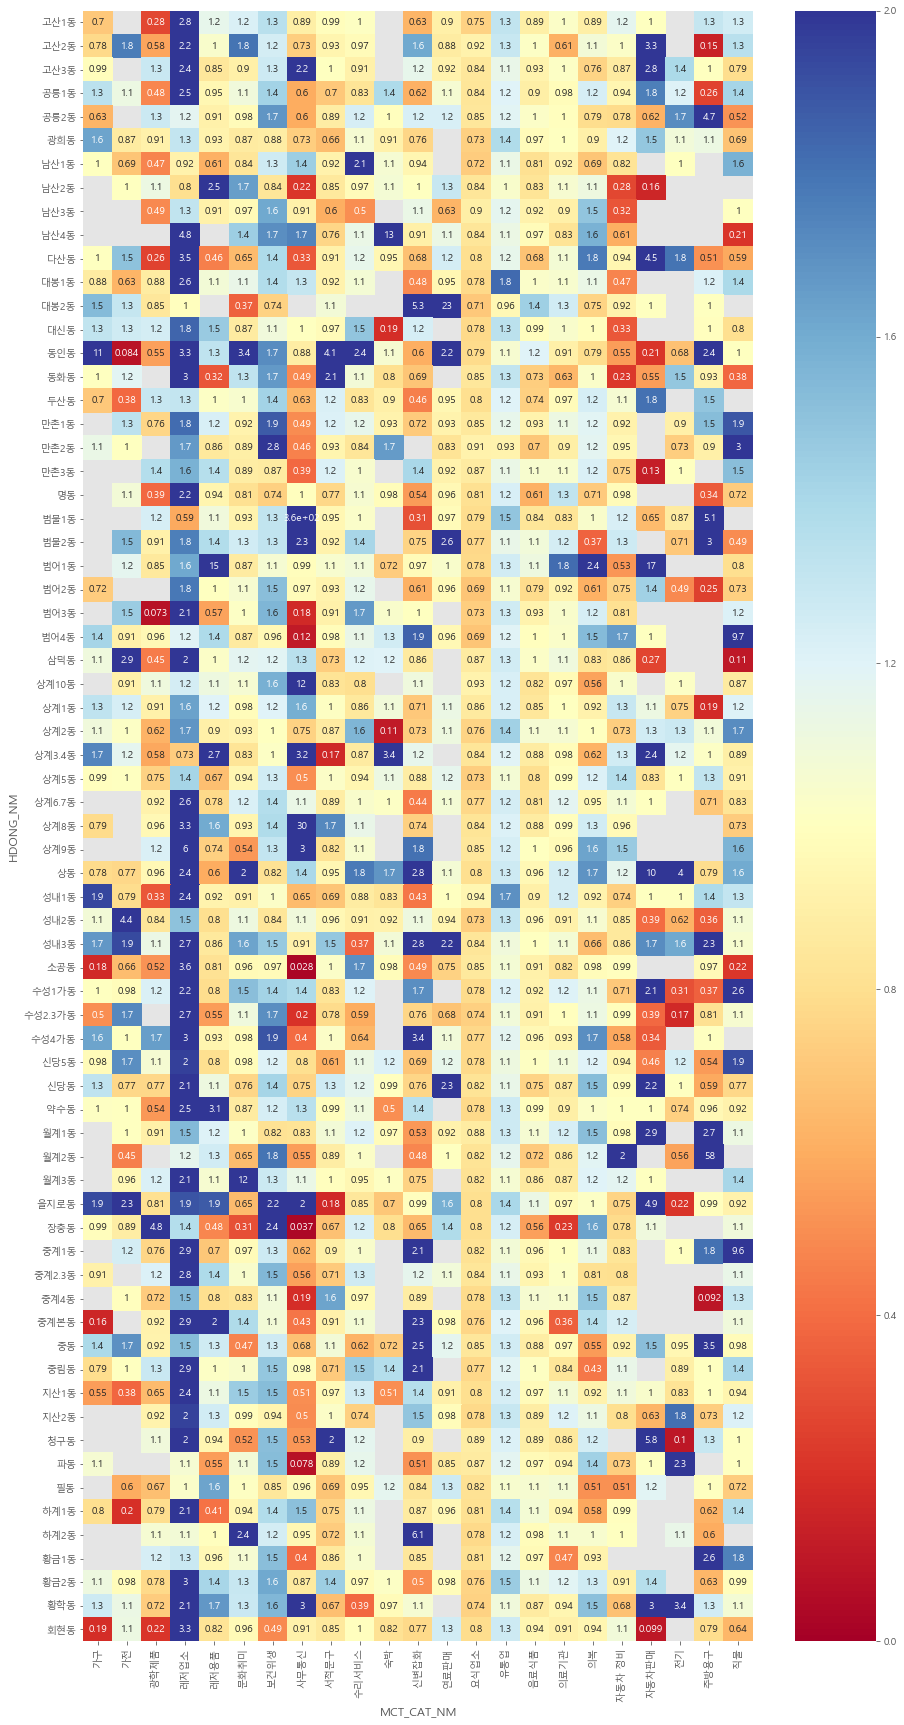

In [186]:
plt.figure(figsize=(15,30))
sns.heatmap(
    SEX_CAT_rate_GUP.pivot('HDONG_NM','MCT_CAT_NM','rate'), cmap='RdYlBu', vmin=0, vmax=2, annot=True
)

* 레저업소에서 여성의 객단가가 남성의 객단가에 비해 매우 높은것으로 파악됨  
 => 악기의 소비가 여성이 더 많다고 판단할 수 있다면 이해할 수 있는 객단가비율 수치로 생각
* 요식업소의 경우 남성의 객단가가 여성의 객단가에 비해 높은것으로 보임. (남성과 여성의 먹는 양에 대한 차이도 어느정도 포함 될 수도?)
* 유통업의 경우는 여성의 객단가가 남성의 객단가에 비해 조금 높은편
* 보건위생의 경우 역시 여성의 객단가가 남성의 객단가에 비해 조금 높은편
* 주방용품의 경우 여성이 높은경우, 남성이 높은경우 고루 분포하고 비율들이 극단적인 편

In [168]:
tmp_df = register.groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','SEX_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup')

#### 연령대별 객단가 

In [11]:
tmp_df = register.groupby(['HDONG_NM','AGE_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','AGE_CD']).\
        apply(lambda x : x.eval('daily_gup = USE_AMT/USE_CNT').daily_gup.rolling(window=1).mean().fillna(method='bfill').mean()).\
        reset_index(name='mean_daily_gup')

In [14]:
from mpl_toolkits.mplot3d import Axes3D

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
le = LabelEncoder()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68]), <a list of 69 Text xticklabel objects>)

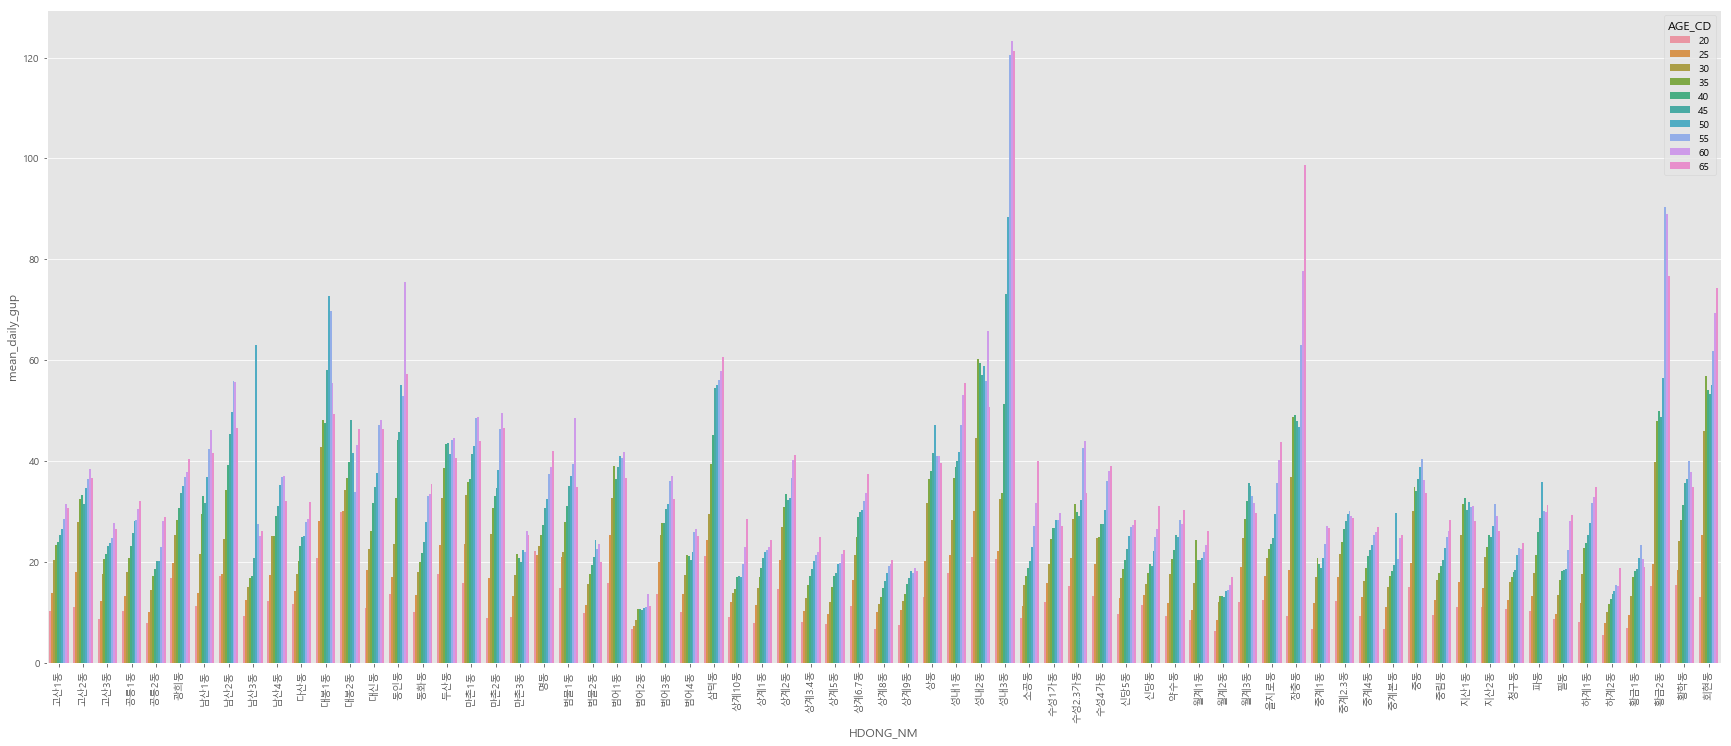

In [42]:
plt.figure(figsize=(30,12))
sns.barplot(
    data = tmp_df,
    x = 'HDONG_NM',
    y = 'mean_daily_gup',
    hue = 'AGE_CD'
)
plt.xticks(rotation=90)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

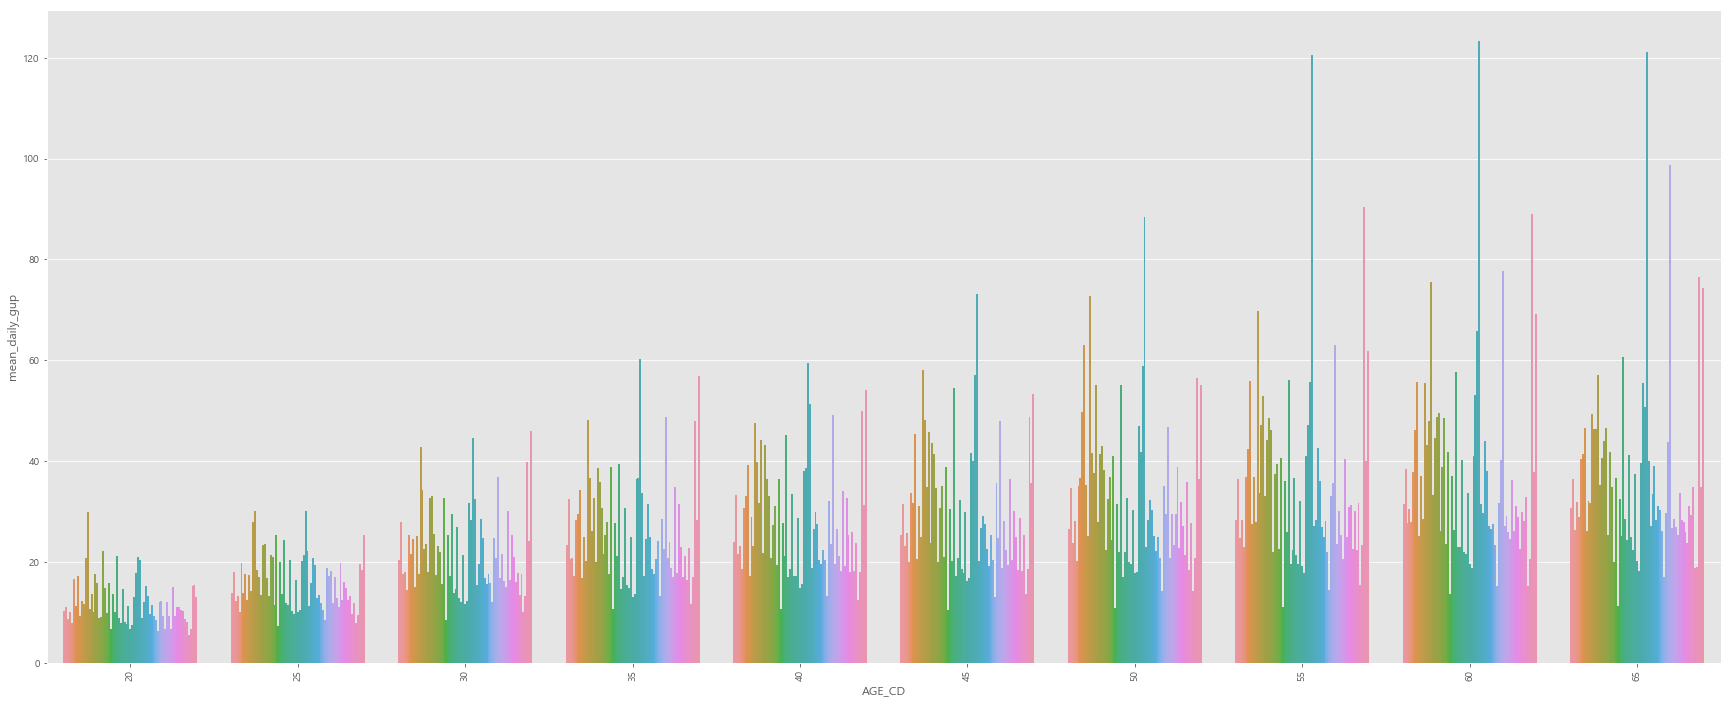

In [52]:
plt.figure(figsize=(30,12))
sns.barplot(
    data = tmp_df,
    x = 'AGE_CD',
    y = 'mean_daily_gup',
    hue = 'HDONG_NM',
)
plt.legend().set_visible(False)
plt.xticks(rotation=90)

* 고연령대(55세 이상)의 객단가가 높게 나옴

#####  연령대 + 카테고리별 객단가

In [85]:
tmp = register.groupby(['HDONG_NM','AGE_CD','MCT_CAT_CD','STD_DD'])[['USE_CNT','USE_AMT']].sum().\
        reset_index().\
        groupby(['HDONG_NM','AGE_CD','MCT_CAT_CD']).\
        apply(lambda x: x.eval('res = USE_AMT/USE_CNT').res.mean()).\
        reset_index(name='mean_cat_gup').\
        pivot_table(index=['HDONG_NM','AGE_CD'], columns='MCT_CAT_CD', values='mean_cat_gup')

In [90]:
cat_dict

{10: '숙박',
 20: '레저용품',
 21: '레저업소',
 22: '문화취미',
 30: '가구',
 31: '전기',
 32: '주방용구',
 33: '연료판매',
 34: '광학제품',
 35: '가전',
 40: '유통업',
 42: '의복',
 43: '직물',
 44: '신변잡화',
 50: '서적문구',
 52: '사무통신',
 60: '자동차판매',
 62: '자동차 정비',
 70: '의료기관',
 71: '보건위생',
 80: '요식업소',
 81: '음료식품',
 92: '수리서비스'}

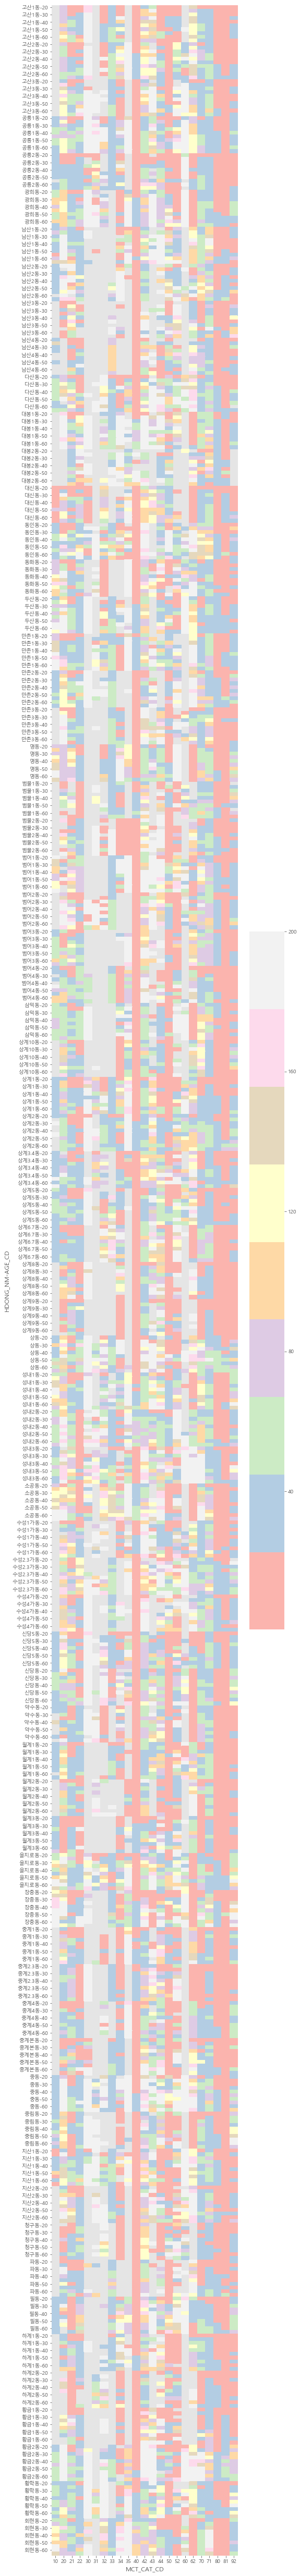

In [95]:
plt.figure(figsize=(8,90))
sns.heatmap(tmp, cmap='Pastel1', vmax=200)

In [74]:
def f2(df):
    return (df.mean_cat_gup / df.mean_cat_gup.cumsum().values[-1]).values

#### 성별,연령대 전체 객단가 

In [97]:
register.groupby(['HDONG_NM','STD_DD'])[['USE_CNT','USE_AMT']].sum().reset_index()

,HDONG_NM,STD_DD,USE_CNT,USE_AMT
0,고산1동,20190201,15384,411993
1,고산1동,20190202,17809,450567
2,고산1동,20190203,16580,391901
3,고산1동,20190204,15604,361414
4,고산1동,20190205,8247,143570
...,...,...,...,...
16624,회현동,20200527,75773,2913451
16625,회현동,20200528,74521,2880475
16626,회현동,20200529,80701,3435369
16627,회현동,20200530,66647,3803298


In [106]:
cat_dict

{10: '숙박',
 20: '레저용품',
 21: '레저업소',
 22: '문화취미',
 30: '가구',
 31: '전기',
 32: '주방용구',
 33: '연료판매',
 34: '광학제품',
 35: '가전',
 40: '유통업',
 42: '의복',
 43: '직물',
 44: '신변잡화',
 50: '서적문구',
 52: '사무통신',
 60: '자동차판매',
 62: '자동차 정비',
 70: '의료기관',
 71: '보건위생',
 80: '요식업소',
 81: '음료식품',
 92: '수리서비스'}

In [11]:
register['MCT_CAT_NM'] = register['MCT_CAT_CD'].map(cat_dict)

In [12]:
register.eval('mean_AMT = USE_AMT/USE_CNT').groupby('MCT_CAT_NM')['mean_AMT'].quantile([.1,.5,.75,.9,.95,.99,.995]).reset_index().pivot('MCT_CAT_NM','level_1','mean_AMT')

level_1,0.100,0.500,0.750,0.900,0.950,0.990,0.995
MCT_CAT_NM,,,,,,,
가구,10.800000,206.875000,564.944444,1267.980000,1895.907500,3679.665000,4604.848000
가전,12.400000,73.200000,242.400000,826.520000,1359.900000,3114.720000,4089.104000
광학제품,6.555556,16.500000,31.000000,142.520000,328.200000,1195.642000,1814.912500
레저업소,3.090909,11.500000,30.400000,86.777778,173.200000,569.200000,805.504000
레저용품,9.000000,53.000000,96.200000,183.981481,276.000000,734.536667,1152.890000
문화취미,4.888889,15.600000,31.800000,62.085315,94.293750,304.753000,530.466566
보건위생,9.000000,25.200000,50.181818,98.928571,156.400000,408.965887,594.216667
사무통신,3.666667,9.166667,22.800000,109.200000,330.542857,936.000000,1531.500000
서적문구,3.218750,12.833333,22.600000,42.000000,70.404444,315.775875,595.200000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

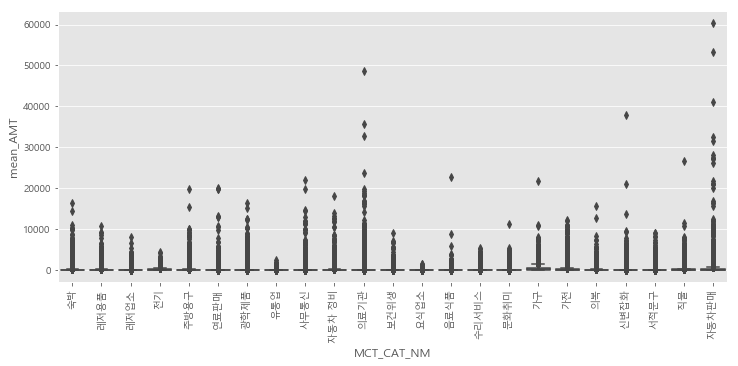

In [13]:
plt.figure(figsize=(12,5))
sns.boxplot(
    data = register.eval('mean_AMT = USE_AMT/USE_CNT'),
    x = 'MCT_CAT_NM',
    y = 'mean_AMT'
)

plt.xticks(rotation=90)

카드데이터 이상치제거 할 수 있는방법 있나??

In [22]:
register

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,mean_AMT
0,20190201,110,517,10,F,25,11,595,110517,동인동,숙박,54.090909
1,20190201,110,517,10,F,50,5,243,110517,동인동,숙박,48.600000
2,20190201,110,517,10,F,55,5,27,110517,동인동,숙박,5.400000
3,20190201,110,517,10,M,20,11,243,110517,동인동,숙박,22.090909
4,20190201,110,517,10,M,25,11,433,110517,동인동,숙박,39.363636
...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,20200531,350,720,81,M,45,19,127,350720,상계10동,음료식품,6.684211
2537749,20200531,350,720,81,M,50,33,211,350720,상계10동,음료식품,6.393939
2537750,20200531,350,720,81,M,55,9,61,350720,상계10동,음료식품,6.777778
2537751,20200531,350,720,81,M,60,19,194,350720,상계10동,음료식품,10.210526


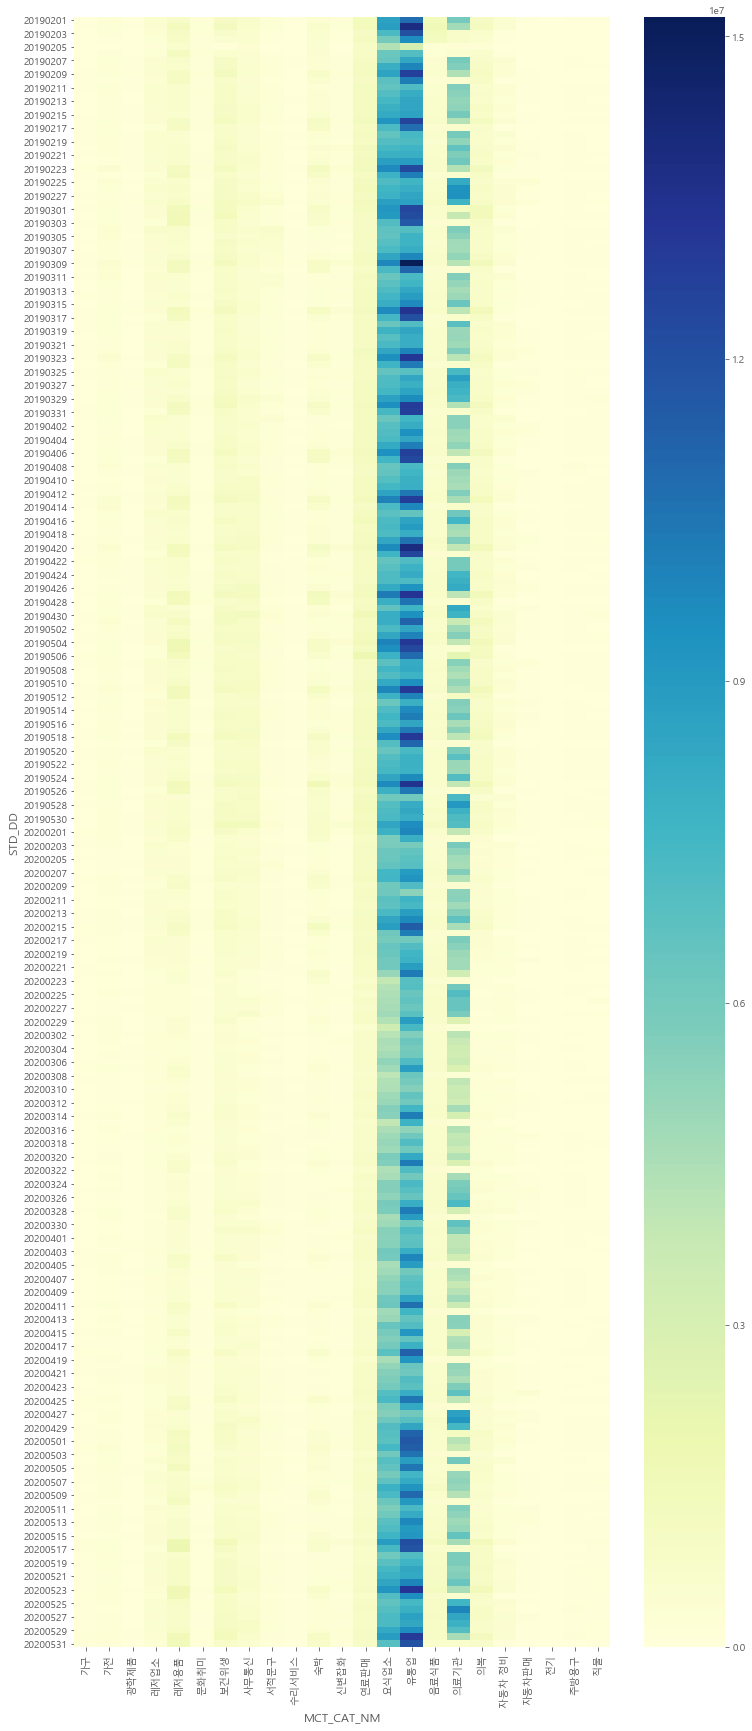

In [26]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.groupby(['MCT_CAT_NM', 'STD_DD']).USE_AMT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','USE_AMT' ).fillna(0),
cmap = 'YlGnBu', vmax= )

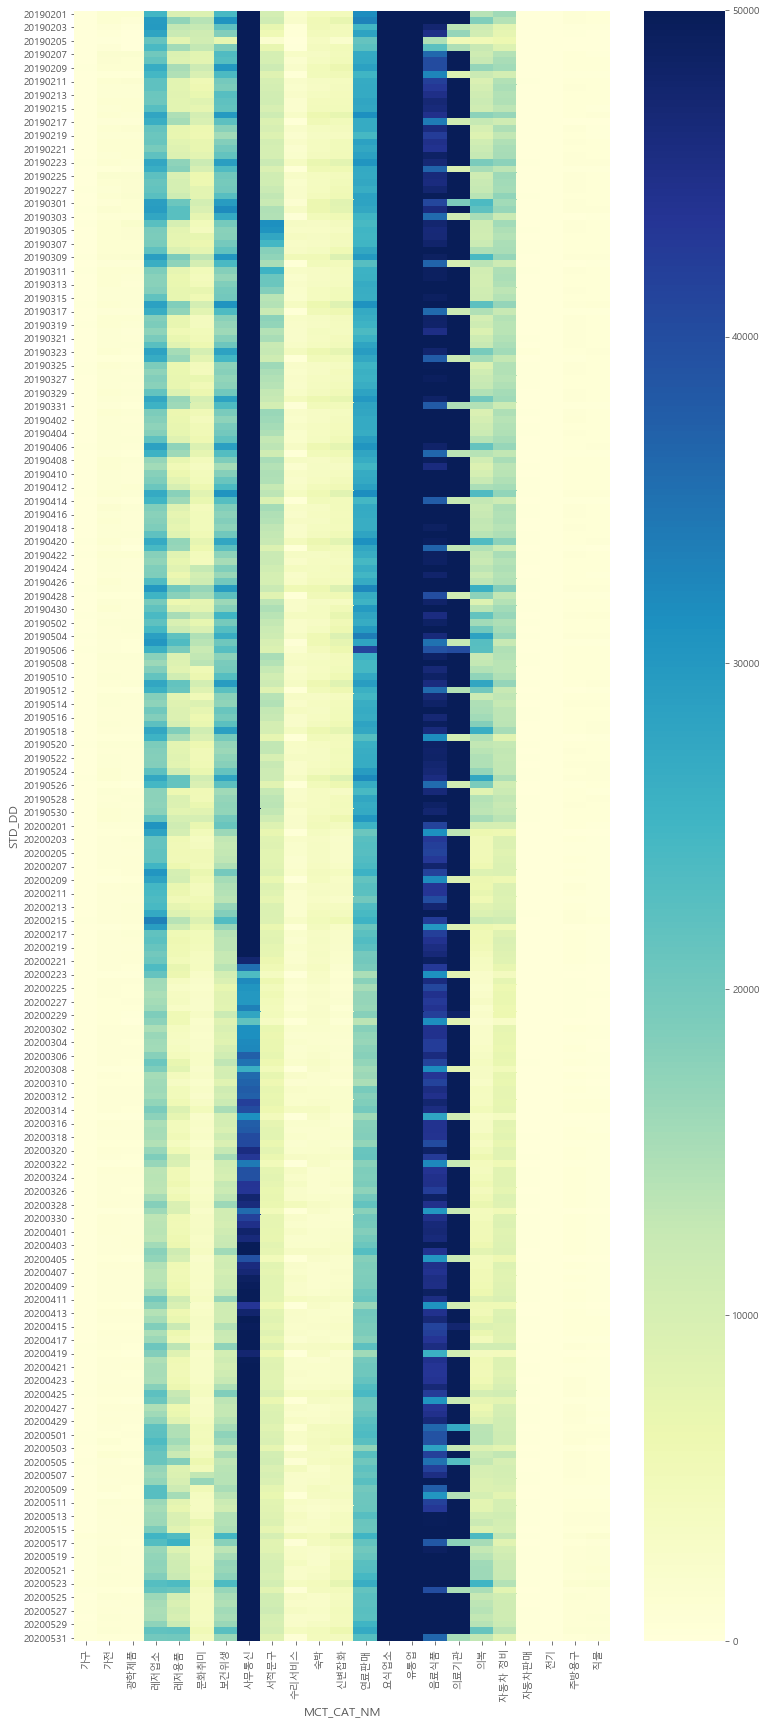

In [27]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.groupby(['MCT_CAT_NM', 'STD_DD']).USE_CNT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','USE_CNT' ).fillna(0),
cmap = 'YlGnBu', vmax=50000)

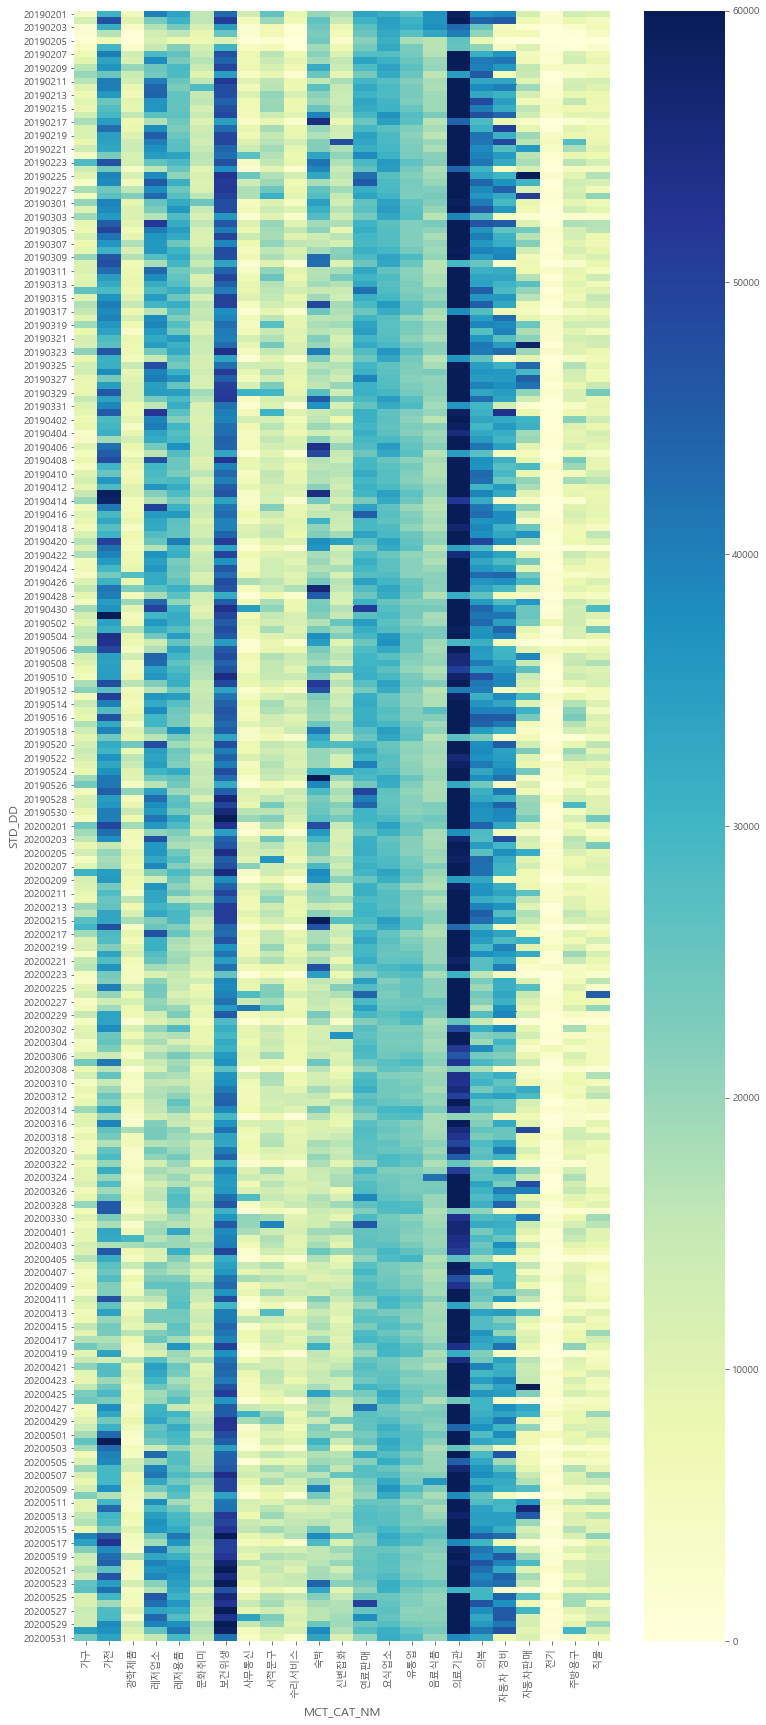

In [21]:
plt.figure(figsize=(12,30))
sns.heatmap(
register.eval('mean_AMT = USE_AMT/USE_CNT').groupby(['MCT_CAT_NM', 'STD_DD']).mean_AMT.sum().reset_index().pivot('STD_DD','MCT_CAT_NM','mean_AMT' ).fillna(0),
cmap = 'YlGnBu', vmax=60000)

In [30]:
register.eval('mean_AMT=USE_AMT/USE_CNT').groupby

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,mean_AMT
0,20190201,110,517,10,F,25,11,595,110517,동인동,숙박,54.090909
1,20190201,110,517,10,F,50,5,243,110517,동인동,숙박,48.600000
2,20190201,110,517,10,F,55,5,27,110517,동인동,숙박,5.400000
3,20190201,110,517,10,M,20,11,243,110517,동인동,숙박,22.090909
4,20190201,110,517,10,M,25,11,433,110517,동인동,숙박,39.363636
...,...,...,...,...,...,...,...,...,...,...,...,...
2537748,20200531,350,720,81,M,45,19,127,350720,상계10동,음료식품,6.684211
2537749,20200531,350,720,81,M,50,33,211,350720,상계10동,음료식품,6.393939
2537750,20200531,350,720,81,M,55,9,61,350720,상계10동,음료식품,6.777778
2537751,20200531,350,720,81,M,60,19,194,350720,상계10동,음료식품,10.210526


### 의류 신변잡화 평균구매금액

In [12]:
register = register.loc[register.MCT_CAT_NM.isin(['의복','신변잡화'])]

In [13]:
register.reset_index(drop=True, inplace=True)

In [14]:
register=register.eval('mean_USE_AMT=USE_AMT/USE_CNT')

In [105]:
import copy

In [108]:
tmp_df = copy.deepcopy(register)

In [109]:
tmp_df.loc[:,'mean_USE_AMT'] = np.log(tmp_df.loc[:,'mean_USE_AMT'])

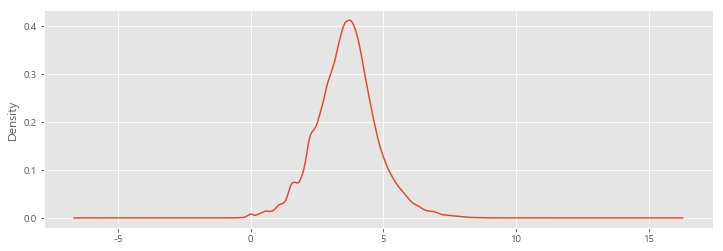

In [114]:
tmp_df.mean_USE_AMT.plot(kind='kde', figsize=(12,4))

In [111]:
tmp_df.mean_USE_AMT.mean()

3.6253235543403965

In [112]:
tmp_df.mean_USE_AMT.std()

1.1393911283913098

In [165]:
def detect_outlier(df, col, method='sigma'):
    # method : 'sigma', 'IQR'
    
    tmp_df = copy.deepcopy(df)
    tmp_df.loc[:,col] = np.log(tmp_df.loc[:,col])
    outlier_indices = []
    for cat in tmp_df.MCT_CAT_NM.unique():
        origin_num = tmp_df.loc[tmp_df.MCT_CAT_NM==cat].shape[0]
        
        if method=='sigma':
            mean_val = tmp_df[col].mean()
            std_val = tmp_df[col].std()

            outlier_index = tmp_df.loc[(df.MCT_CAT_NM==cat) & (tmp_df[col] >= mean_val+2*std_val)].index

            outlier_indices.extend(outlier_index)
            outliers_num = len(outlier_index)
        elif method=='IQR':
            Q1,Q3 = tmp_df.loc[tmp_df.MCT_CAT_NM==cat,col].quantile([.25,.75]).values
            IQR = Q3-Q1
            
            outlier_index = tmp_df.loc[(df.MCT_CAT_NM==cat) & (tmp_df[col] > Q3+1.5*IQR)].index
            outlier_indices.extend(outlier_index)
            outliers_num  = len(outlier_index)
        else:
            msg = f'{method} is not provided method'
            raise ValueError(msg)
        
        print(f'{cat} 이상치 비율 : {outliers_num/origin_num:.2%}')
    return outlier_indices

In [145]:
# detect_outlier(register, 'mean_USE_AMT')

In [166]:
format(len(detect_outlier(register, 'mean_USE_AMT'))/register.shape[0], '.2%')

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


'3.04%'

In [167]:
register.iloc[detect_outlier(register, 'mean_USE_AMT')].groupby(['MCT_CAT_NM','year']).size().reset_index()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


,MCT_CAT_NM,year,0
0,신변잡화,2019,713
1,신변잡화,2020,772
2,의복,2019,1488
3,의복,2020,1434


In [168]:
register.iloc[detect_outlier(register, 'mean_USE_AMT')].mean_USE_AMT.quantile([.05,.06,.07,.08,.09, .1, .5, .75, .9, .99])

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


0.05     379.400000
0.06     382.098182
0.07     385.248392
0.08     388.600000
0.09     391.500000
0.10     394.383590
0.50     600.800000
0.75     977.319444
0.90    1656.000000
0.99    4540.000000
Name: mean_USE_AMT, dtype: float64

In [169]:
outliers=register.iloc[detect_outlier(register, 'mean_USE_AMT')].groupby(['MCT_CAT_NM','year'])['USE_CNT','USE_AMT'].sum().reset_index()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


In [170]:
drop_outlier=register.drop(detect_outlier(register, 'mean_USE_AMT')).groupby(['MCT_CAT_NM','year'])['USE_CNT','USE_AMT'].sum().reset_index()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


In [162]:
outliers

,MCT_CAT_NM,year,USE_CNT,USE_AMT
0,신변잡화,2019,7588,6244794
1,신변잡화,2020,6677,6068938
2,의복,2019,13722,9265139
3,의복,2020,11664,8448826


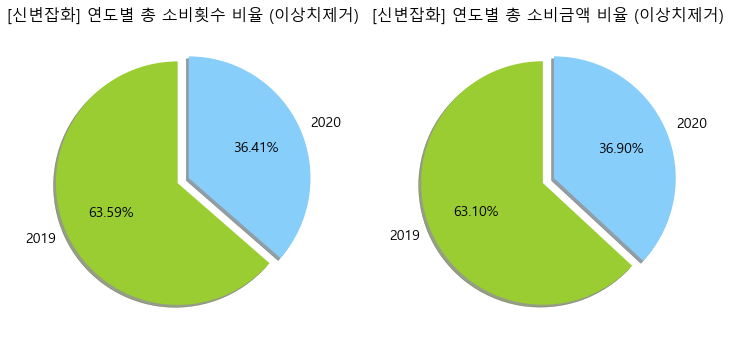

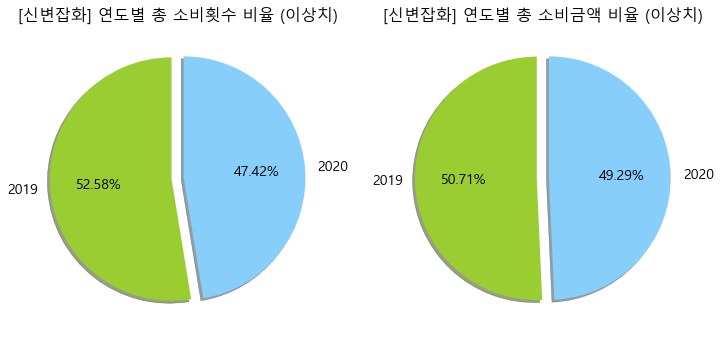

In [171]:
########################################
### 이상치제거 데이터 (drop_outlier) ###
########################################

group_names = drop_outlier.year.unique().tolist()
group_sizes = drop_outlier.loc[drop_outlier.MCT_CAT_NM=='신변잡화'].USE_CNT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.title('[신변잡화] 연도별 총 소비횟수 비율 (이상치제거)  ', fontsize=16)

# information of groups
group_names = drop_outlier.year.unique().tolist()
group_sizes = drop_outlier.loc[drop_outlier.MCT_CAT_NM=='신변잡화'].USE_AMT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.subplot(122)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.title('[신변잡화] 연도별 총 소비금액 비율 (이상치제거)  ', fontsize=16)
plt.show()

########################################

###############################
### 이상치 데이터(outliers) ###
###############################
# information of groups
group_names = outliers.year.unique().tolist()
group_sizes = outliers.loc[outliers.MCT_CAT_NM=='신변잡화'].USE_CNT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
#plt.axis('equal') #  equal length of X and Y axis
plt.title('[신변잡화] 연도별 총 소비횟수 비율 (이상치)  ', fontsize=16)


plt.subplot(122)
# information of groups

group_sizes = outliers.loc[outliers.MCT_CAT_NM=='신변잡화'].USE_AMT.tolist()

plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
#plt.axis('equal') #  equal length of X and Y axis
plt.title('[신변잡화] 연도별 총 소비금액 비율 (이상치)  ', fontsize=16)
plt.show()

###############################

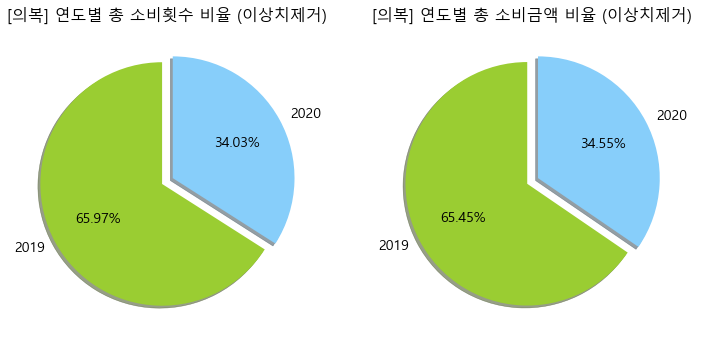

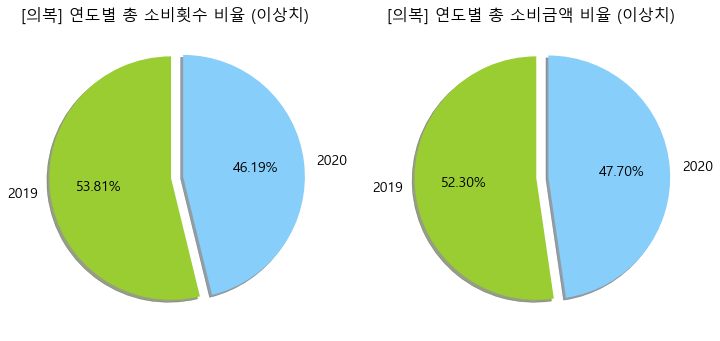

In [180]:
########################################
### 이상치제거 데이터 (drop_outlier) ###
########################################

group_names = drop_outlier.year.unique().tolist()
group_sizes = drop_outlier.loc[drop_outlier.MCT_CAT_NM=='의복'].USE_CNT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.title('[의복] 연도별 총 소비횟수 비율 (이상치제거)  ', fontsize=16)

# information of groups
group_names = drop_outlier.year.unique().tolist()
group_sizes = drop_outlier.loc[drop_outlier.MCT_CAT_NM=='의복'].USE_AMT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0.1, 0) # explode 1st slice

plt.subplot(122)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
plt.title('[의복] 연도별 총 소비금액 비율 (이상치제거)  ', fontsize=16)
plt.show()

########################################

###############################
### 이상치 데이터(outliers) ###
###############################
# information of groups
group_names = outliers.year.unique().tolist()
group_sizes = outliers.loc[outliers.MCT_CAT_NM=='의복'].USE_CNT.tolist()
group_colors = ['yellowgreen', 'lightskyblue']
group_explodes = (0, 0.1) # explode 1st slice

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
#plt.axis('equal') #  equal length of X and Y axis
plt.title('[의복] 연도별 총 소비횟수 비율 (이상치)  ', fontsize=16)


plt.subplot(122)
# information of groups

group_sizes = outliers.loc[outliers.MCT_CAT_NM=='의복'].USE_AMT.tolist()

plt.pie(group_sizes, 
        explode=group_explodes, 
        labels=group_names, 
        colors=group_colors, 
        autopct='%1.2f%%', # second decimal place
        shadow=True, 
        startangle=90,
        textprops={'fontsize': 14}) # text font size
#plt.axis('equal') #  equal length of X and Y axis
plt.title('[의복] 연도별 총 소비금액 비율 (이상치)  ', fontsize=16)
plt.show()

###############################

* 의복, 신변잡화 모두 이상치를 제거하면 19년 대비 20년 소비횟수는 절반정도로 줄었으나 이상치 데이터의 경우 그 수의 변화가 크지 않았다
* 위 데이터에서 이상치 판단 기준이 결제액 평균이었고, 명품 의류, 잡화 등의 구매기록을 제외하려 하였음.
* 이상치가 잘 탐지되어 분류되었다면, 명품의 경우 소비횟수 및 소비금액에서 감소가 적었다고 볼 수 있다.

In [44]:
register.drop(detect_outlier(register, 'mean_USE_AMT'))

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,year,month,weekofyear,dayofweek,weekday,mean_USE_AMT
0,2019-02-01,110,545,42,F,20,287,8450,110545,삼덕동,의복,2019,2,5,4,평일,29.442509
1,2019-02-01,110,545,42,F,25,162,4629,110545,삼덕동,의복,2019,2,5,4,평일,28.574074
2,2019-02-01,110,545,42,F,30,32,2430,110545,삼덕동,의복,2019,2,5,4,평일,75.937500
3,2019-02-01,110,545,42,F,35,27,1389,110545,삼덕동,의복,2019,2,5,4,평일,51.444444
4,2019-02-01,110,545,42,F,40,32,1400,110545,삼덕동,의복,2019,2,5,4,평일,43.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145192,2020-05-31,350,720,44,F,25,5,94,350720,상계10동,신변잡화,2020,5,22,6,주말,18.800000
145193,2020-05-31,350,720,44,F,55,5,51,350720,상계10동,신변잡화,2020,5,22,6,주말,10.200000
145194,2020-05-31,350,720,44,M,45,14,185,350720,상계10동,신변잡화,2020,5,22,6,주말,13.214286
145195,2020-05-31,350,720,44,M,50,5,225,350720,상계10동,신변잡화,2020,5,22,6,주말,45.000000


의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


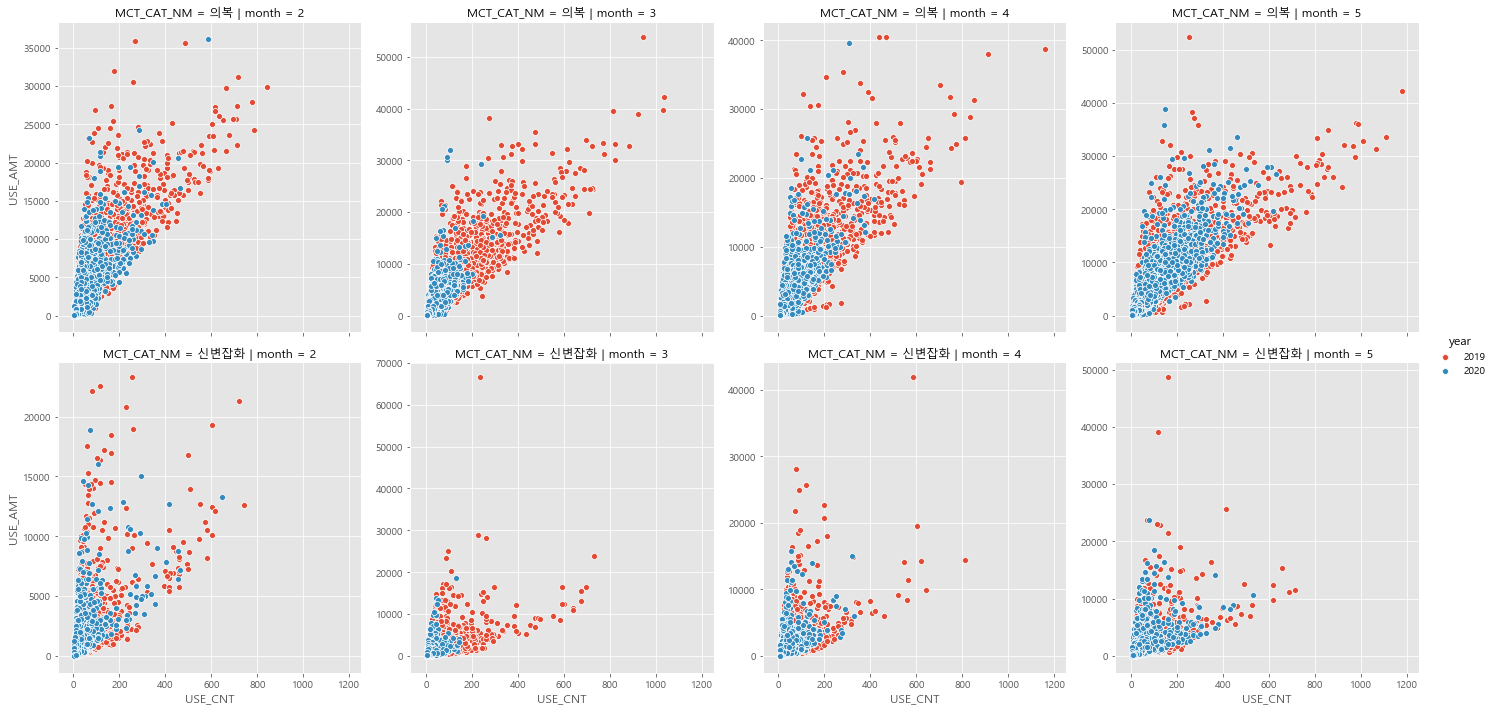

In [173]:
g = sns.FacetGrid(data=register.drop(detect_outlier(register, 'mean_USE_AMT')), height=5, aspect=1,row='MCT_CAT_NM', col='month', hue='year',sharey=False)
g.map(sns.scatterplot, 'USE_CNT','USE_AMT').add_legend()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


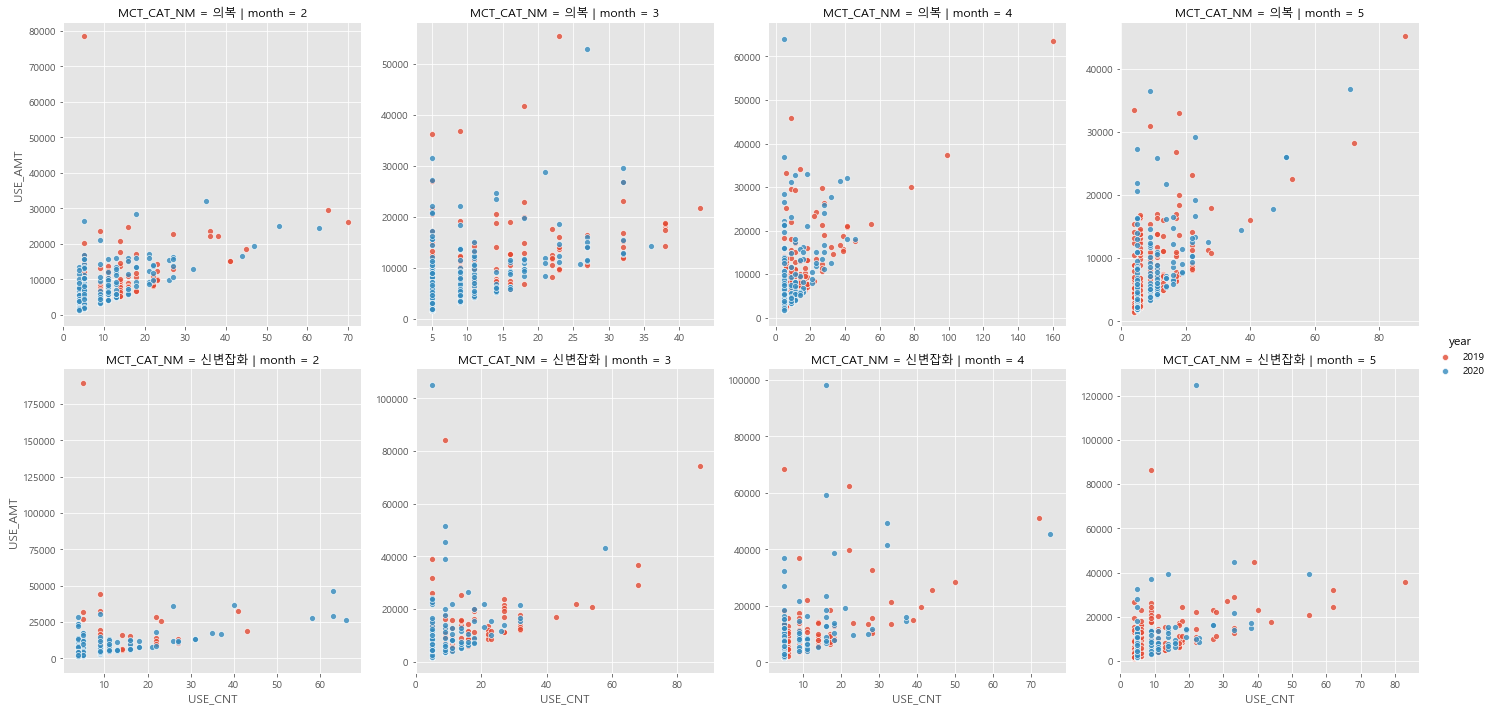

In [176]:
g = sns.FacetGrid(data=register.iloc[detect_outlier(register, 'mean_USE_AMT')], height=5, aspect=1,row='MCT_CAT_NM', col='month', hue='year', sharex=False,sharey=False)
g.map(sns.scatterplot, 'USE_CNT','USE_AMT', alpha=.8).add_legend()

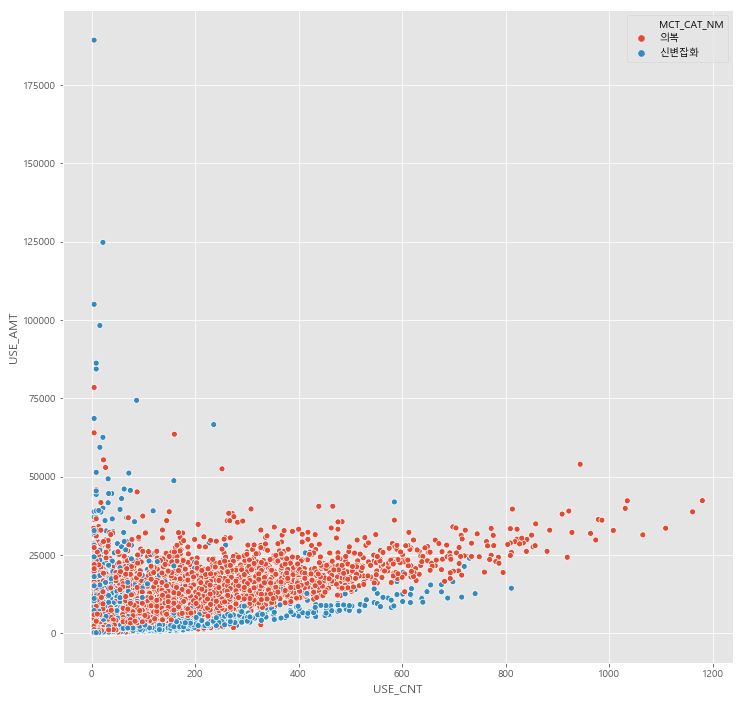

In [18]:
plt.figure(figsize=(12,12))
sns.scatterplot(
    data = register,
    x = 'USE_CNT',
    y = 'USE_AMT',
    hue = 'MCT_CAT_NM'
)

In [ ]:
plt.plot()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%
의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


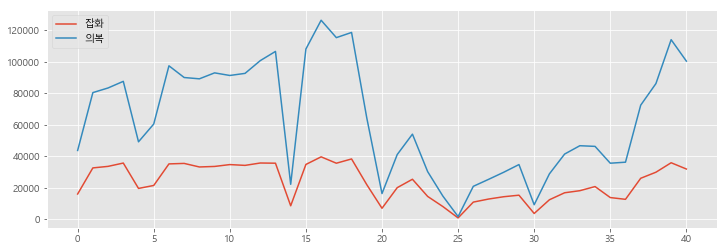

In [185]:
register.drop(detect_outlier(register, 'mean_USE_AMT')).query('MCT_CAT_NM==\'신변잡화\'').groupby(['year','month','weekofyear'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='잡화')
register.drop(detect_outlier(register, 'mean_USE_AMT')).query('MCT_CAT_NM==\'의복\'').groupby(['year','month','weekofyear'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='의복')

plt.legend()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%
의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


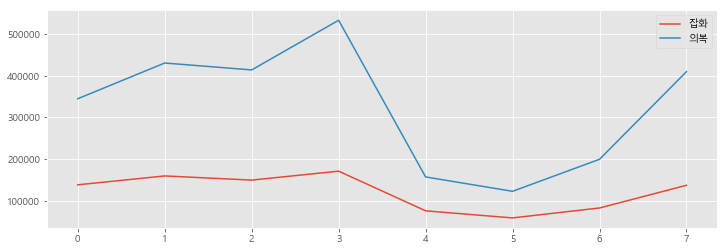

In [187]:
register.drop(detect_outlier(register, 'mean_USE_AMT')).query('MCT_CAT_NM==\'신변잡화\'').groupby(['year','month'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='잡화')
register.drop(detect_outlier(register, 'mean_USE_AMT')).query('MCT_CAT_NM==\'의복\'').groupby(['year','month'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='의복')

plt.legend()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%
의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


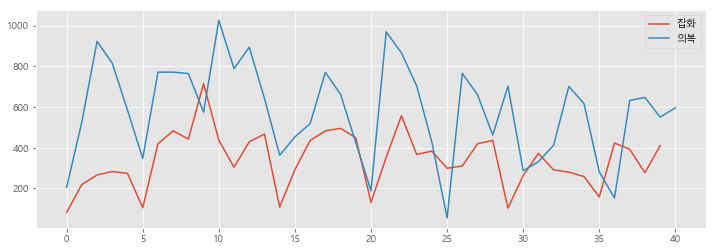

In [186]:
register.iloc[detect_outlier(register, 'mean_USE_AMT')].query('MCT_CAT_NM==\'신변잡화\'').groupby(['year','month','weekofyear'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='잡화')
register.iloc[detect_outlier(register, 'mean_USE_AMT')].query('MCT_CAT_NM==\'의복\'').groupby(['year','month','weekofyear'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='의복')

plt.legend()

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%
의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


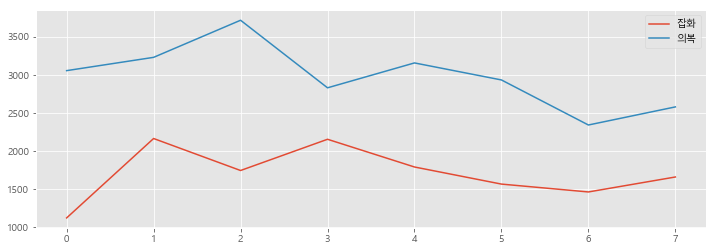

In [188]:
register.iloc[detect_outlier(register, 'mean_USE_AMT')].query('MCT_CAT_NM==\'신변잡화\'').groupby(['year','month'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='잡화')
register.iloc[detect_outlier(register, 'mean_USE_AMT')].query('MCT_CAT_NM==\'의복\'').groupby(['year','month'])['USE_CNT'].sum().reset_index().USE_CNT.plot(figsize=(12,4), label='의복')

plt.legend()

In [189]:
register.drop(detect_outlier(register, 'mean_USE_AMT')).query('MCT_CAT_NM==\'신변잡화\'')

의복 이상치 비율 : 3.08%
신변잡화 이상치 비율 : 2.95%


,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,year,month,weekofyear,dayofweek,weekday,mean_USE_AMT
19,2019-02-01,110,545,44,F,20,54,1097,110545,삼덕동,신변잡화,2019,2,5,4,평일,20.314815
20,2019-02-01,110,545,44,F,25,38,447,110545,삼덕동,신변잡화,2019,2,5,4,평일,11.763158
21,2019-02-01,110,545,44,F,30,22,419,110545,삼덕동,신변잡화,2019,2,5,4,평일,19.045455
23,2019-02-01,110,545,44,F,40,11,157,110545,삼덕동,신변잡화,2019,2,5,4,평일,14.272727
24,2019-02-01,110,545,44,M,20,32,409,110545,삼덕동,신변잡화,2019,2,5,4,평일,12.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145192,2020-05-31,350,720,44,F,25,5,94,350720,상계10동,신변잡화,2020,5,22,6,주말,18.800000
145193,2020-05-31,350,720,44,F,55,5,51,350720,상계10동,신변잡화,2020,5,22,6,주말,10.200000
145194,2020-05-31,350,720,44,M,45,14,185,350720,상계10동,신변잡화,2020,5,22,6,주말,13.214286
145195,2020-05-31,350,720,44,M,50,5,225,350720,상계10동,신변잡화,2020,5,22,6,주말,45.000000


#### 평균 구매금액 구간(Qcut)별 차이

In [206]:
qcut=pd.qcut(register.mean_USE_AMT, 20)

In [224]:
register.loc[register.MCT_CAT_NM=='신변잡화','mean_USE_AMT'] = pd.qcut(register.loc[register.MCT_CAT_NM=='신변잡화','mean_USE_AMT'],20)
register.loc[register.MCT_CAT_NM=='의복','mean_USE_AMT'] = pd.qcut(register.loc[register.MCT_CAT_NM=='의복','mean_USE_AMT'],20)

In [225]:
register.groupby(["MCT_CAT_NM",'year','month','qcut'])['USE_CNT'].sum().reset_index().groupby(['MCT_CAT_NM','month','qcut']).apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1]).reset_index(name='diff').query('MCT_CAT_NM==\'신변잡화\'').pivot('qcut','month','diff')

month,2,3,4,5
qcut,,,,
0,-0.173551,-0.162064,-0.199326,-0.033345
1,-0.669879,-0.602879,-0.479179,-0.384517
2,-0.404884,-0.407391,-0.296415,0.052260
3,-0.218698,-0.572215,-0.409034,-0.079609
4,-0.539362,-0.695864,-0.512265,-0.352954
5,-0.355373,-0.725819,-0.449606,-0.219196
6,-0.521082,-0.647950,-0.572190,-0.250229
7,-0.527926,-0.704774,-0.473329,-0.021565
8,-0.582468,-0.770431,-0.449821,-0.343473


In [226]:
register.groupby(["MCT_CAT_NM",'year','month','qcut'])['USE_CNT'].sum().reset_index().groupby(['MCT_CAT_NM','month','qcut']).apply(lambda x : (x.iloc[1,-1]-x.iloc[0,-1])/x.iloc[0,-1]).reset_index(name='diff').query('MCT_CAT_NM==\'의복\'').pivot('qcut','month','diff')

month,2,3,4,5
qcut,,,,
0,0.667345,0.220600,-0.088404,-0.146002
1,-0.036268,0.347916,-0.327764,-0.345769
2,0.044856,-0.142909,-0.083628,-0.096484
3,-0.347255,-0.194798,-0.163980,-0.148499
4,-0.027240,-0.222598,-0.405314,-0.274611
5,-0.235463,-0.246009,-0.193033,-0.404110
6,-0.254344,-0.505133,-0.371022,-0.448127
7,-0.370772,-0.583251,-0.533845,-0.554771
8,-0.637766,-0.713468,-0.559371,-0.555948


In [221]:
register

,STD_DD,GU_CD,DONG_CD,MCT_CAT_CD,SEX_CD,AGE_CD,USE_CNT,USE_AMT,region_code,HDONG_NM,MCT_CAT_NM,year,month,weekofyear,dayofweek,weekday,mean_USE_AMT,qcut
0,2019-02-01,110,545,42,F,20,287,8450,110545,삼덕동,의복,2019,2,5,4,평일,29.442509,8
1,2019-02-01,110,545,42,F,25,162,4629,110545,삼덕동,의복,2019,2,5,4,평일,28.574074,7
2,2019-02-01,110,545,42,F,30,32,2430,110545,삼덕동,의복,2019,2,5,4,평일,75.937500,15
3,2019-02-01,110,545,42,F,35,27,1389,110545,삼덕동,의복,2019,2,5,4,평일,51.444444,12
4,2019-02-01,110,545,42,F,40,32,1400,110545,삼덕동,의복,2019,2,5,4,평일,43.750000,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145192,2020-05-31,350,720,44,F,25,5,94,350720,상계10동,신변잡화,2020,5,22,6,주말,18.800000,5
145193,2020-05-31,350,720,44,F,55,5,51,350720,상계10동,신변잡화,2020,5,22,6,주말,10.200000,2
145194,2020-05-31,350,720,44,M,45,14,185,350720,상계10동,신변잡화,2020,5,22,6,주말,13.214286,3
145195,2020-05-31,350,720,44,M,50,5,225,350720,상계10동,신변잡화,2020,5,22,6,주말,45.000000,11
